# Recommender Evaluation
### By Nicholas Roze-Freitas and Coby Wilcox

_To reduce boilerplate, code for visualizations and transformations can be found in visualization_modules.py and data_processing_modules.py respectively_

## Abstract
Recommender systems are an often behind the scenes but rather foundational aspect of life today. Usually when we engage with media, we are engaging with a recommender: using social media, reading the news, buying something online and much more. Regardless of how ubiquitous recommenders are, evaluating and making them presents interesting and unique problems. Recommenders get evaluated on several different metrics of accuracy: serendipity, novelty, robustness, accuracy and coverage to name a few. Through this project we evaluate the performance of several recommender system models and frameworks, and how we might improve them in the context of the Microsoft News Dataset. Through this report we start with an exploration of our dataset, create model pipelines and then evaluate and report findings. Below is an exploration of our dataset and its features.

## Exploratory data analysis

Before evaluating any recommender frameworks, models or hyperparameters, we will be engaging in exploratory data analysis on the Microsoft News Dataset. The Microsoft news dataset contains 4 separate tab-separated files: behaviors entity_embeddings, news and relation_embeddings. The main focus for now will be on behaviors and news, which gives us data on the catalog and users with interactions respectively. 

In [2]:
## IMPORTS ## REMOVE IMPORTS NOT EDA_MODULES ONCE DONE ##
import visualization_modules 
import data_processing_modules as data_processing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime as datetime


### Changing file formats
We first noticed that our files were in unlabeled .tsv files, to make our data analysis easier in the future these .tsv files were turned into csvs with columns as specified by the datasets github repo. Once these columns were created, exploratory data analysis could be performed more easily.

### Initial understanding
Within the MIND dataset (might want to make it clear that the mind dataset is referring to the microsoft news dataset at some point so that it is more clear to the reader) there are two main files, the behaviors and news. News contains information on the articles that users interact with like its ID, category, sub-category, title, abstract, url and some entities for use within embeddings (to my understanding). Behaviors focuses on impression ids, user ids, time, user history and impressions. Since there are two main datasets, we will be starting with some examination of each, and then examination of how they might interact.

In [3]:
news = pd.read_csv('../MIND_small/csv/news.csv')
news.head(2)

,Unnamed: 0,news_id,category,sub_category,title,abstract,url,title_entities,abstract_entities
0,0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."


## Starting with news
As noticeable above, there are columns for categories and subcategories. As these categories will be utilized to improve recommendations we will start our analysis of the news dataset by taking a quick peak at how many categories there may be, and what sorts of sub-categories we'll find in each via a treemap. 

In [4]:
fig = visualization_modules.plot_sub_categories(news)
fig.show()

Within this initial peak we can see that our biggest categories are news and sports, whereas music, movies and entertainment make up the smallest. In content-filtering recommenders differing sizes of categories can lower the quality of recommendations as categories with more items are more likely to have higher counts of users that have interacted with them thus increasing the frequency that they are recommended. Consequently this can affected success metrics; improper management could cause a dip in coverage and serendipity as the recommender system will not make as wide a selection of recommendations. Through further analysis we can explore the option of applying an inverse category frequency weight to balance our recommendations within content-filtering recommenders.

### Checking Counts of Categories
Moving on, we will now check the distribution of our categories more properly.

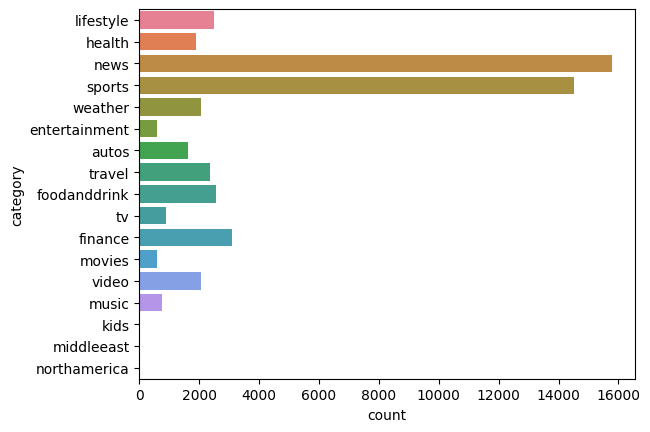

In [5]:
fig = visualization_modules.plot_categories(news)
# Might want to consider sorting so the figure can make better sense, also considering matching colors with the px graph above

Confirming what we saw earlier, news and sports are still our biggest main categories, however new categories not previoulsy seen in our peek such as kids, middleeast and northamerica appear. These latter 3 categories contain so few observations that its unlikely that a user has interacted with them. To ameliorate this, we will see if any users have interacted with articles from these categories and remove the categories depending on the results after we load in the behaviors data.

### Missing Values in News
Most missing values are in the abstract with only a few in title_entities and abstract_entities. An abstract briefly summarizes an articles content; by turning abstracts into embeddings we can create a feature that uses similarity of embeddings to recommend news. While there are missing many values we experimented with ignoring them altogether or utilizing a summarization model like T5 to generate new abstracts for the articles.

In [6]:
missing_vals = news.isna().sum()
missing_vals

Unnamed: 0              0
news_id                 0
category                0
sub_category            0
title                   0
abstract             2666
url                     0
title_entities          3
abstract_entities       4
dtype: int64

## Moving on to Behaviors
The other half of the Microsoft News Dataset is the behaviors file; detailing user interactions, history, and times, the behaviors file provides our recommenders important training data. Due to the inclusion of a timestamp for interactions we examined the temporal context of interactions and created traditional training and testing splits based off of time frames as detailed further below.

In [7]:
behaviors = pd.read_csv('../MIND_small/csv/behaviors.csv').drop(columns='Unnamed: 0')
behaviors.head(2)

,impression_id,user_id,time,history,impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...


### Missing values in behaviors
Before showcasing more of our analysis we first discuss the missing values in behaviors.

In [8]:
behaviors.isna().sum()

impression_id       0
user_id             0
time                0
history          3238
impressions         0
dtype: int64

The only column containing missing values is the history column which can have an effect on the efficacy of a sequential recommender. As it is the history column, this implies that there are new users who's first interactions have been logged and have yet to have a history. (look more into history column). This creates a major issue for sequential recommenders, which utilize a users history to create new recommendations. 

When evaluating the Tensorflow sequential recommender, we removed rows that included missing values for history. For other recommender models we added a layer that was able to provide recommendations based off of other features.

### Article and Category Popularity
We then analyzed the popularity of each category and article in the dataset. Each interaction in the dataset has information specific to that interaction: time and clickthrough rates for recommended articles. From this, we determined the popularity of articles and categories in regards to history, clickthrough rate and both. Code relating to the extrapolation of this data can be found in data_processing_modules.py.

### Categories
By checking the popularity of categories we can 

c:\Users\nicho\anaconda3\envs\recSysEnv\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



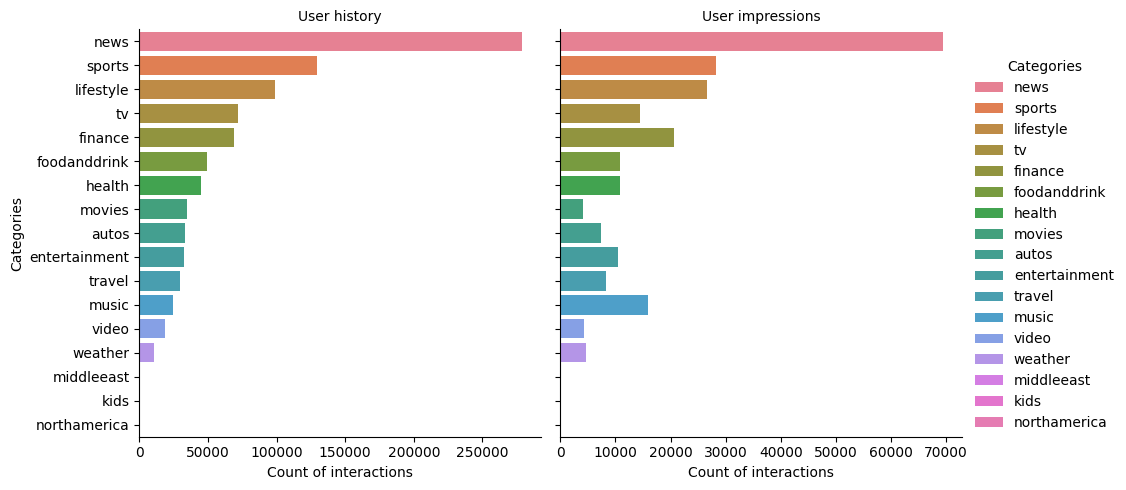

In [9]:
category_popularity = pd.read_csv('../MIND_small/csv/category_with_popularity.csv').drop(columns=['Unnamed: 0'])
visualization_modules.plot_category_popularity(category_popularity) # Add order to the barplot function
del category_popularity
# Remove the unnamed: 0 column from the dataframe again in plot_category_popularity

By comparing the above chart with the chart describing density of each category we notice that the count of articles in a category does not impact the overall popularity of that category. TV has less articles than weather and yet is much more popular amongst users. It's clear from earlier distribitutions that certain categories have larger catalogs and popularity. To see if category and popularity density affects the quality of recommendations we later experiment with a potential weighting system modeled after IDF with categories that are more prevalent. 

### Addressing the Long Tail
Something that can arise when creating recommenders is the long tail problem; an issue where certain items have a disproportionate number of ratings which can skew recommendations. As visible in the distributions of popularity for both categories and specific articles, there is a long tail. To ameliorate this we experimented with different methods of applying a pseudo-idf to categories and articles to help lesser known articles appear more in recommendations.

### Amputation
Given that there are categories that have little to no articles or interactions, we will not include them in our recommender framework testing as their overall impact is both negligible and reducing the quality of visualizations.

In [10]:
# news = pd.read_csv('../MIND_small/csv/news.csv') 
# news = news[news['category'] not in ['kids', 'middleeast', 'northamerica']]
# news.to_csv('fpath') # Can update later on when necessary.

### Idea? analyzing the categories a user likes in relation to their other categories

## Accessing temporal aspects of our data
Within the user behaviors data is a feature denoting the time stamp of their interaction, before comitting to using this as a feature we analyzed popularity counts at different hours of the day. Additionally we utilized this column to split training and testing data in classic recommender fashion.

In [11]:
# list(news.category.unique())
news.category.unique()

array(['lifestyle', 'health', 'news', 'sports', 'weather',
       'entertainment', 'autos', 'travel', 'foodanddrink', 'tv',
       'finance', 'movies', 'video', 'music', 'kids', 'middleeast',
       'northamerica'], dtype=object)

In [12]:
behaviors = pd.read_csv('../MIND_small/csv/behaviors_with_individual_counts.csv')
unique_user_histories = behaviors.drop_duplicates(subset='user_id')[['user_id', 'time'] + [category + '_history' for category in news['category'].unique()]]
behaviors = behaviors.drop(columns=[category + '_history' for category in news['category'].unique()])

In [13]:
behaviors = data_processing.modify_hourly(behaviors)
behaviors.head()
behaviors = behaviors.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'impression_id', 'history', 'impressions'])

In [14]:
unique_user_histories = data_processing.modify_hourly(unique_user_histories)

In [15]:
behaviors2 = behaviors.groupby('hour').agg('sum').reset_index()
unique_user_histories2 = unique_user_histories.groupby('hour').agg('sum').reset_index()

### Side note on what is below 
Below is some work on changing the way that popularity is interpreted. For every hour the total number of interactions is calculated and the percentage of the interactions that a category makes up is charted as its popularity.

In [16]:
cols = ['lifestyle', 'health', 'news', 'sports', 'weather', 'entertainment', 'autos', 'travel', 'foodanddrink', 'tv', 'finance', 'movies', 'video', 'music', 'kids', 'middleeast', 'northamerica']
impression_ = []
history_ = []
for col in cols:
    impression_.append(col + '_impression')
    history_.append(col + '_history')

In [17]:
unique_user_histories2['history_div'] = unique_user_histories2[history_].apply(lambda x : sum(x), axis=1)
behaviors2['impression_div'] = behaviors2[impression_].apply(lambda x : sum(x), axis=1)

In [19]:
unique_user_histories2[history_] = unique_user_histories2.apply(lambda x : x[history_] / x['history_div'], axis=1)
behaviors2[impression_] = behaviors2.apply(lambda x : x[impression_] / x['impression_div'], axis=1)

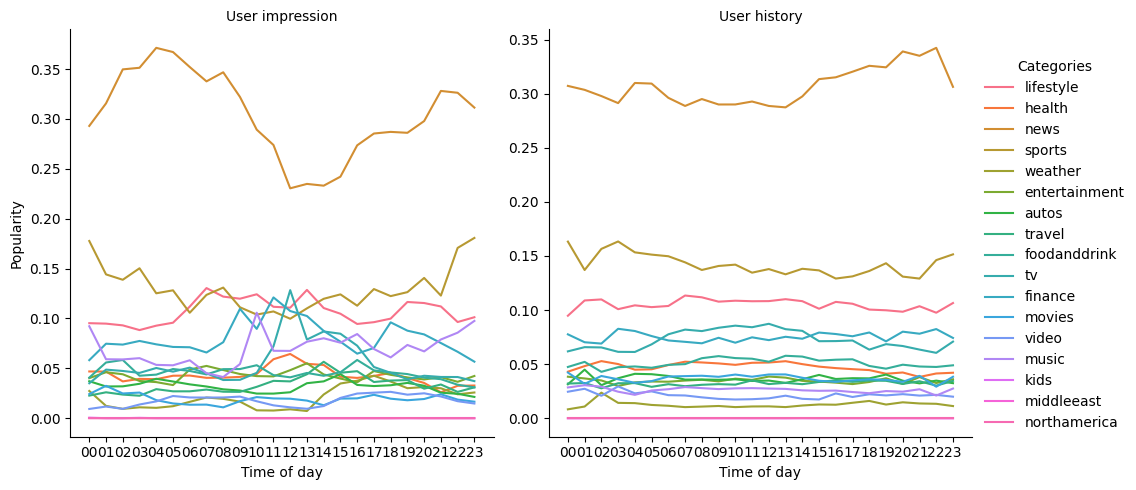

In [20]:
visualization_modules.create_temporal_graphs(behaviors2, unique_user_histories2)

#### Observations
As visible above, the time of day has more of an affect on the popularity of certain categories for user impressions. Whereas in regards to user history, all categories have a steady incline in popularity until the middle of the day, from which they start to decrease until the evening. As a consequence of certain categories being more popular at certain times for user impressions, we include time of day as a feature in our recommendation system evaluation.

#### Clustering observations.
Lastly, we explored clustering to determine if there are any natural groupings to be found within the data. Starting with clustering of the item catalogue we leveraged a pre-trained BERT model to add embeddings to the 'Abstract' and 'Title' columns respectively. Once applied we encoded the categorical variables and utilized uniform manifold projection aka UMAP to apply clustering and visualize the results. 